In [1]:
# Gain modulation RNN with oja learning on weight matrix, nonlinear lqg, ongoing oja
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from rnn import RNN
import json
from torch.autograd.functional import jacobian
from torch import tensor
import torch
import torch.nn as nn
import scipy.linalg as sp_linalg

## Loading Trained Weights

In [2]:
with open('../weights/sinwave_oja_60_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'weight_sums', 'gain_changes'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weights = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])

## Defining Network

In [11]:
time_constant = 100 #ms
timestep = 10 #ms
time = 100000 #ms
T_max = time // timestep
num_inputs = 1
num_nodes = 60
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

# define inputs and targets
dt = network.timestep/network.time_const
T = np.arange(0, T_max)

time_points = np.arange(T_max).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

In [12]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float(), input_weights) 

100%|██████████| 10000/10000 [00:00<00:00, 14155.89it/s]


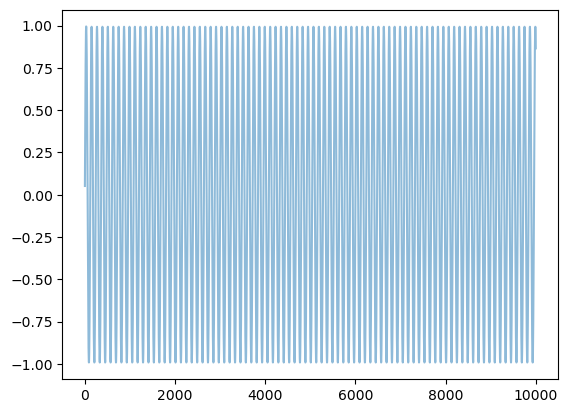

In [13]:
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='simu')

## Manual Simulatation

In [14]:
class myrnn():
    def __init__(self, weights, gains, shifts, connectivity_matrix):
        # core parameters
        self.weights = weights
        self.gains = gains
        self.shifts = shifts
        self.activation_func = nn.Sigmoid()

        # transfer into tensor
        self.weights_tensor = tensor(self.weights)
        self.gains_tensor = tensor(self.gains)
        self.shifts_tensor = tensor(self.shifts)
        
        # weight type
        self.weight_type = self.weights >= 0
        self.connectivity_matrix = connectivity_matrix

    def f_tensor(self, x_tensor, u_tensor):
        y_tensor = (1 - dt) * x_tensor + dt * self.activation_func(self.gains_tensor * (torch.matmul(self.weights_tensor, x_tensor) + u_tensor - self.shifts_tensor))
        return y_tensor
    
    def f(self, x, u):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        y_tensor = self.f_tensor(x_tensor, u_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        dydx, dydu = jacobian(self.f_tensor,(x_tensor, u_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        return Jx, Ju

jnn_ff = myrnn(weight_matrix, gains, shifts, connectivity_matrix)
jnn = myrnn(weight_matrix, gains, shifts, connectivity_matrix)

In [15]:
# define matrices
c = np.eye(num_nodes)
Bnoise = np.eye(num_nodes)
W = np.eye(num_nodes) * 0.001
V = np.eye(num_nodes) * 0.001
Q = np.eye(num_nodes) * 1
R = np.eye(num_nodes) * 0.01

# define noise
np.random.seed(42)
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=W, size=len(T))).T
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=V, size=len(T))).T
# x_noises[:,0:50] = 0
# x_noises[:,50:60] += 0.1
# x_noises[:,60:150] = 0
# x_noises[:,150:160] += 0.1
# x_noises[:,160:300] = 0
# x_noises *= 0
noise_time = np.arange(50, 1000, 120)
for t in noise_time:
    x_noises[:,t:t+10] += 0.1

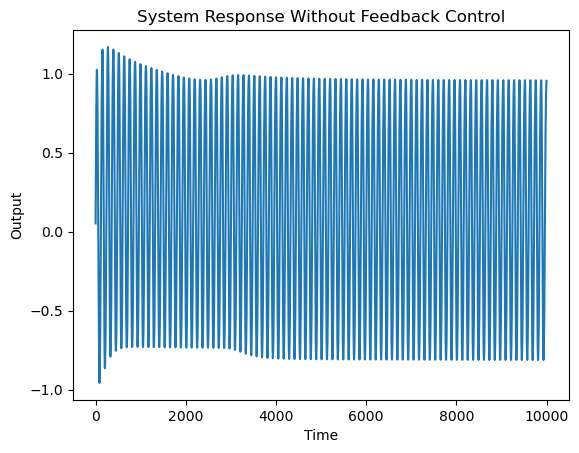

In [16]:
# Simulation Without Control
x = init_activations.copy()
u = init_activations.copy()
xs = []
ys = []
outputs_o = []

oja_alpha = np.sqrt(num_nodes)
hebbian_lr = 0.001
weightss = []


for i in T:
    
    # update x
    this_input = inputs[i] * input_weights.T
    u = this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1) * 0
    x1 = jnn_ff.f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    output = output_weight_matrix @ x
    
    # save
    xs.append(x)
    ys.append(y)
    outputs_o.append(output.item())

    # Oja's rule
    hebbian_update = x @ x.T
    hebbian_update = hebbian_update * jnn_ff.weight_type * jnn_ff.connectivity_matrix
    # rj_square = (x**2).expand(-1, num_nodes)
    x_square = x**2
    rj_square = np.broadcast_to(x_square, (x_square.shape[0], num_nodes))
    oja_regulation = oja_alpha * rj_square * jnn_ff.weights * jnn_ff.weight_type * jnn_ff.connectivity_matrix
    jnn_ff.weights = jnn_ff.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation
    jnn_ff.weights_tensor = tensor(jnn_ff.weights)
    # print(jnn_ff.weights[1,6])
    weightss.append(jnn_ff.weights.copy())
    # print(x[1], x[2])
    # print(np.sum(jnn_ff.weights* jnn_ff.weight_type * jnn_ff.connectivity_matrix))

# Plot the output
plt.plot(T, outputs_o)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

In [17]:
good_weights = (jnn_ff.weight_type * jnn_ff.connectivity_matrix).flatten().astype(bool)
weightss_1 = [x.flatten() for x in weightss]
weightss_2 = np.column_stack(weightss_1)
weightss_3 = weightss_2[good_weights, :]

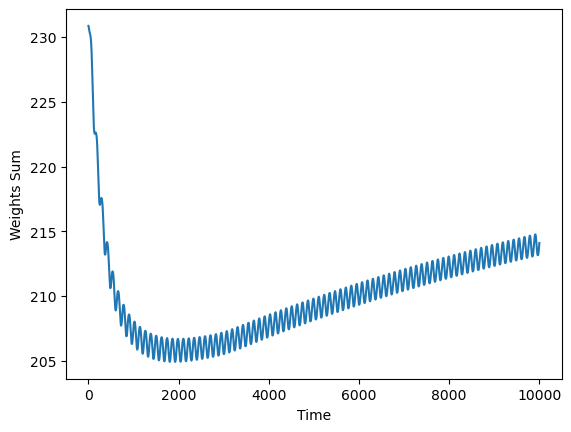

In [18]:
weights_sum = [np.sum(w) for w in weightss]
plt.xlabel("Time")
plt.ylabel("Weights Sum")
plt.plot(weights_sum)
plt.show()

(0.0, 0.2)

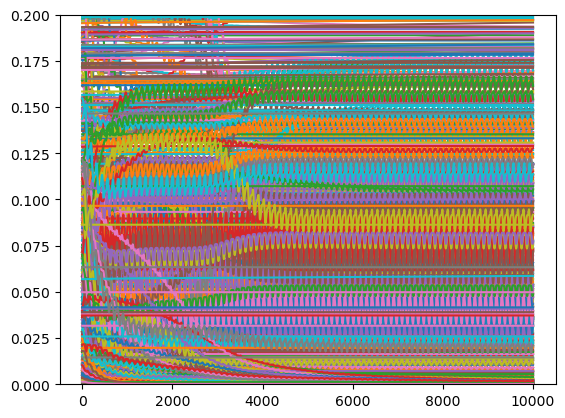

In [19]:
for i in range(1000):
    plt.plot(weightss_3[i, :])
plt.ylim([0, 0.2])

In [220]:
(jnn_ff.weights* jnn_ff.weight_type * jnn_ff.connectivity_matrix).round(3)

array([[ 0.   , -0.   ,  0.037, ...,  0.162,  0.219,  0.005],
       [ 0.002,  0.   ,  0.001, ...,  0.138,  0.023,  0.   ],
       [ 0.2  , -0.   ,  0.   , ...,  0.155,  0.241,  0.012],
       ...,
       [ 0.002, -0.   ,  0.001, ...,  0.   ,  0.032,  0.   ],
       [ 0.022, -0.   ,  0.004, ...,  0.156,  0.   ,  0.001],
       [ 0.282, -0.   ,  0.286, ...,  0.236,  0.225,  0.   ]])

In [221]:
rj_square.round(3)

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.206, 0.206, 0.206, ..., 0.206, 0.206, 0.206],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.964, 0.964, 0.964, ..., 0.964, 0.964, 0.964],
       [0.519, 0.519, 0.519, ..., 0.519, 0.519, 0.519],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [222]:
(x**2).round(3)

array([[0.   ],
       [0.206],
       [0.   ],
       [0.   ],
       [0.875],
       [0.   ],
       [0.   ],
       [0.399],
       [0.045],
       [0.414],
       [0.484],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.304],
       [0.608],
       [0.29 ],
       [0.649],
       [0.872],
       [0.994],
       [0.007],
       [0.   ],
       [0.207],
       [0.689],
       [0.964],
       [0.57 ],
       [0.987],
       [0.12 ],
       [0.548],
       [0.   ],
       [0.994],
       [0.   ],
       [0.842],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [0.   ],
       [1.   ],
       [0.   ],
       [0.   ],
       [0.435],
       [0.001],
       [0.578],
       [0.   ],
       [0.85 ],
       [0.   ],
       [1.   ],
       [0.638],
       [0.   ],
       [0.985],
       [0.   ],
       [0.   ],
       [0.916],
       [0.002],
       [0.702],
       [0.   ],
       [0.964],
       [0.519],
       [0.   ]])

In [223]:
hebbian_update.round(3)

array([[0.   , 0.   , 0.   , ..., 0.011, 0.008, 0.   ],
       [0.005, 0.   , 0.   , ..., 0.446, 0.328, 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.011, 0.   , 0.   , ..., 0.   , 0.708, 0.   ],
       [0.008, 0.   , 0.   , ..., 0.708, 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [224]:
oja_regulation.round(3)

array([[ 0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.004,  0.   ,  0.001, ...,  0.22 ,  0.036,  0.   ],
       [ 0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.018, -0.   ,  0.004, ...,  0.   ,  0.234,  0.001],
       [ 0.09 , -0.   ,  0.018, ...,  0.628,  0.   ,  0.003],
       [ 0.   , -0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [225]:
jnn_ff.weights.round(3)

array([[ 0.   , -0.116,  0.037, ...,  0.162,  0.219,  0.005],
       [ 0.002,  0.   ,  0.001, ...,  0.138,  0.023,  0.   ],
       [ 0.2  , -0.334,  0.   , ...,  0.155,  0.241,  0.012],
       ...,
       [ 0.002, -0.006,  0.001, ...,  0.   ,  0.032,  0.   ],
       [ 0.022, -0.037,  0.004, ...,  0.156,  0.   ,  0.001],
       [ 0.282, -0.128,  0.286, ...,  0.236,  0.225,  0.   ]])

In [226]:
jnn_ff.weight_type

array([[ True, False,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       ...,
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])

In [227]:
np.sum((jnn_ff.weights >= 0).astype(int) - jnn_ff.weight_type.astype(int))

0

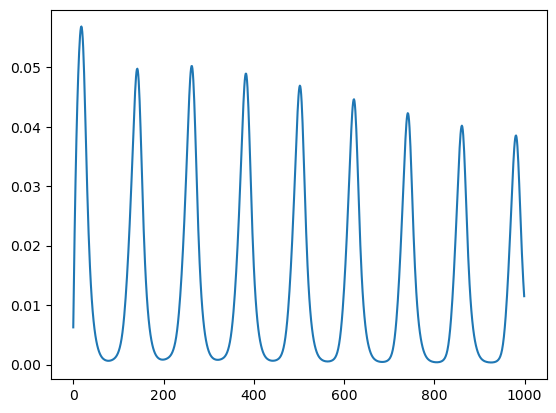

In [228]:
x1s = [x[0].item() for x in xs]
plt.plot(T, x1s)
plt.show()

### Non-linear LQG

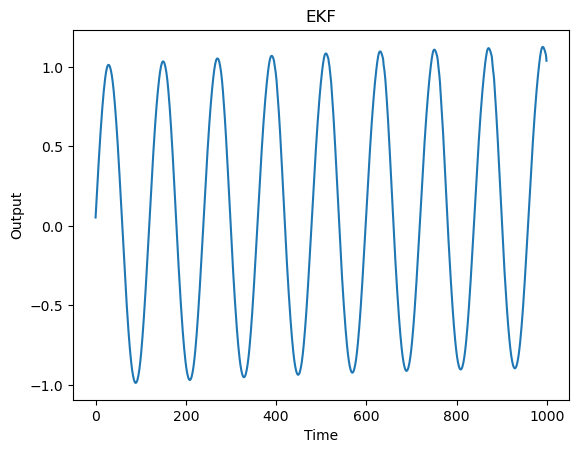

In [229]:
ideal_activations = activations.detach().numpy()
x = init_activations.copy()
u = init_activations.copy()
xhat = init_activations.copy()
Phat = W.copy()
xs = []
ys = []
ctrlus = []
xhats = []
outputs_b = []

oja_alpha = np.sqrt(num_nodes)
hebbian_lr = 0.001
weightss = []

for i in T:

    # Update x
    this_input = inputs[i] * input_weights.T
    u = u + this_input.copy()
    process_noise = x_noises[:,i].reshape(-1,1) * 0
    x1 = jnn.f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    measurement_noise = y_noises[:,i].reshape(-1,1) * 0
    y = c @ x + measurement_noise
    output = output_weight_matrix @ x

    # Save
    xs.append(x)
    ys.append(y)
    outputs_b.append(output.item())

    # Kalman
    xpred = jnn.f(xhat, u)
    F, _ = jnn.jacob(xhat, u)
    Ppred = F @ Phat @ F.T + W
    ypred = c @ xpred

    S = c @ Ppred @ c.T + V
    Kf = Ppred @ c.T @ np.linalg.inv(S)

    xhat = xpred + Kf @ (y - ypred)
    phat = Ppred - Kf @ c @ Ppred
    yres = y - c @ xhat

    xhats.append(xhat)

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    A, B = jnn.jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    u = -K @ (xhat - this_ideal_activation)
    ctrlus.append(u)
    # print(np.mean(u))

    # Oja's rule
    hebbian_update = x @ x.T
    hebbian_update = hebbian_update * jnn.weight_type * jnn.connectivity_matrix
    # rj_square = (x**2).expand(-1, num_nodes)
    x_square = x**2
    rj_square = np.broadcast_to(x_square, (x_square.shape[0], num_nodes))
    oja_regulation = oja_alpha * rj_square * jnn.weights * jnn.weight_type * jnn.connectivity_matrix
    jnn.weights = jnn.weights + hebbian_lr * hebbian_update - hebbian_lr * oja_regulation
    jnn.weights_tensor = tensor(jnn.weights)
    # print(np.mean(jnn.weights))
    weightss.append(jnn.weights.copy())

# Plot the state
# outputhats = [(output_weight_matrix @ x).item() for x in xhats]
plt.plot(T, outputs_b)
# plt.plot(T, outputs_o)
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('EKF')
plt.show()

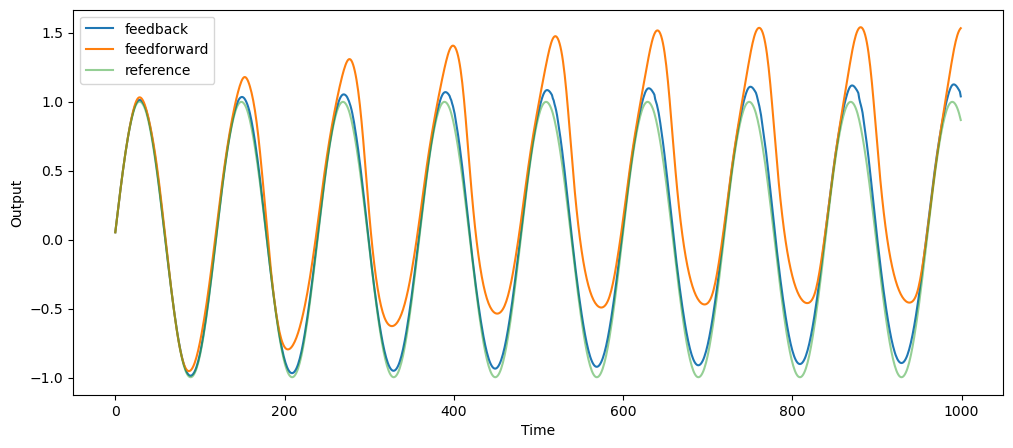

In [230]:
noises_out = (output_weight_matrix @ x_noises).squeeze()

plt.subplots(figsize=(12,5))
plt.plot(T, outputs_b, label='feedback')
plt.plot(T, outputs_o, label='feedforward')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='reference')
# plt.plot(T, noises_out, alpha=0.2, color='black', label='noise')
plt.xlabel('Time')
plt.ylabel('Output')
# plt.title('LQG')
plt.legend()
# plt.savefig("fig/sin_oja_lqg_learn.pdf")

Text(0, 0.5, 'MS of control signal')

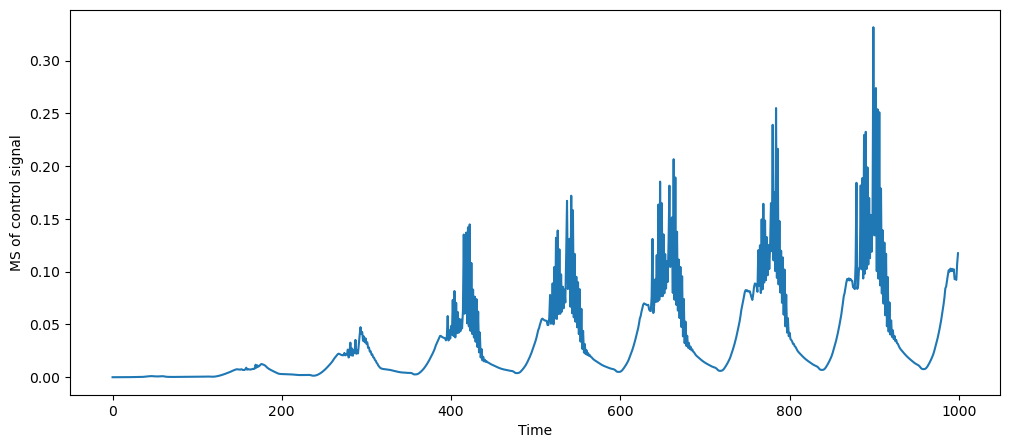

In [231]:
plt.subplots(figsize=(12,5))
umeans = [np.mean(u**2).item() for u in ctrlus]
plt.plot(T, umeans)
plt.xlabel('Time')
plt.ylabel('MS of control signal')
# plt.savefig("fig/sin_oja_lqg_learn_umean.pdf")

Text(0, 0.5, 'MS of control signal')

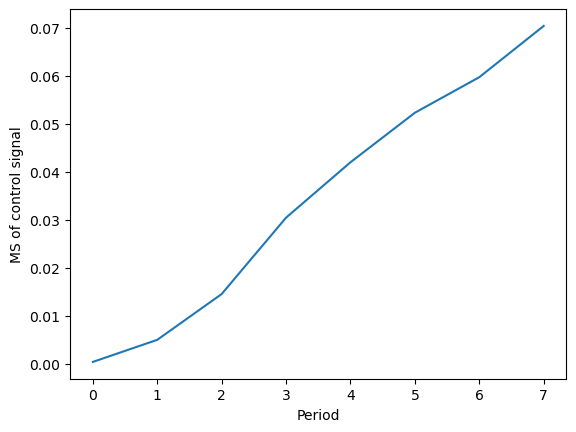

In [232]:
period_starts = np.arange(0, 1000, 120)
period_umeans = []
for t in period_starts:
    if t + 120 < 1000:
        period_umean = np.mean(umeans[t:t+120])
        period_umeans.append(period_umean)
plt.plot(period_umeans)
plt.xlabel('Period')
plt.ylabel('MS of control signal')
# plt.savefig("fig/sin_oja_lqg_learn_umean_period.png")

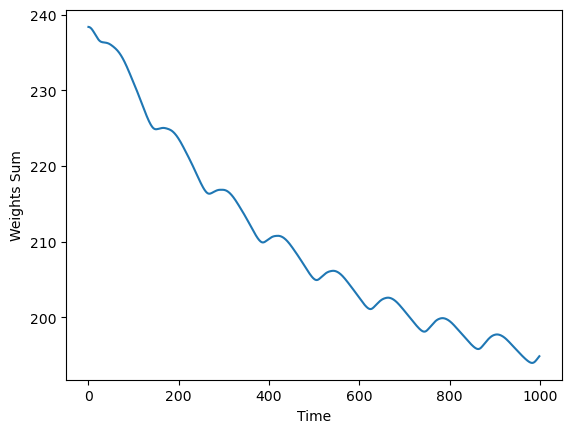

In [233]:
weights_sum = [np.sum(w) for w in weightss]
plt.xlabel("Time")
plt.ylabel("Weights Sum")
plt.plot(weights_sum)
# plt.savefig("fig/sin_oja_lqg_learn_weightsum.png")